<a href="https://colab.research.google.com/github/bforoura/GenAI/blob/main/Module8/pretrained_shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pretrained Models**

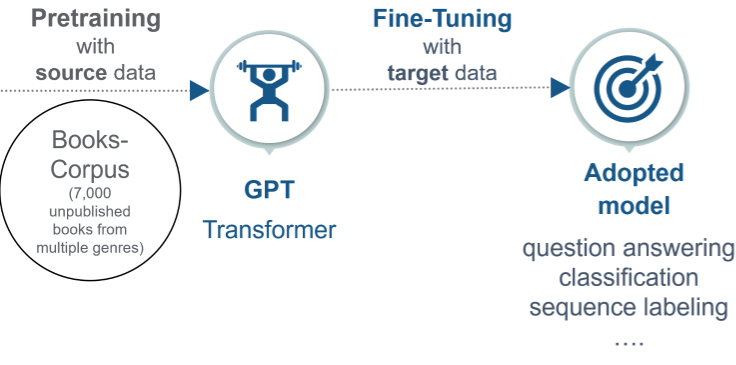

* A **pretrained model** is a machine learning model that has already been trained on a large and general dataset before being adapted to specific tasks.

* The key advantage of using pretrained models is that they have already learned general knowledge and patterns from massive amounts of data, which allows them to be quickly adapted to specific tasks with relatively smaller datasets.

* Pretraining involves training a model on a large-scale, general-purpose task, such as language modeling, before using it for specific downstream tasks.




# **Why Pretraining?**

Training a deep learning model like GPT-2 from scratch on a specific task can be computationally expensive and require a massive amount of labeled data.
 Pretraining allows us to:

1.  **Leverage General Knowledge**: The pretrained model learns general language structures, word relationships, and basic world knowledge, which can then be applied to a wide range of specific tasks.


2. **Reduce Resource Requirements**: By using a pretrained model, we can save time and computational resources because the model has already been trained on large datasets and only needs to be fine-tuned for specific tasks.

3. **Enable Transfer Learning**: Pretrained models are versatile and can be easily adapted to multiple tasks (e.g., text classification, summarization, or text generation) by fine-tuning on a smaller, task-specific dataset.



# **GPT-2 Pretraining**

GPT-2 (Generative Pre-trained Transformer 2) is a large language model trained on a diverse dataset to predict the next word in a sequence. It uses a **transformer-based architecture** to understand and generate human language.

1. **Training Objective**: GPT-2 is trained using a causal language modeling objective, where it learns to predict the next token (e.g., word or subword unit) given the previous tokens in the sequence.

2. **Massive Dataset**: GPT-2 was pre-trained on a large dataset called WebText, which contains text from a variety of sources (e.g., news articles, books, websites) and includes billions of words. This allows the model to learn general language patterns.

3. **Transformer Architecture**: The core of GPT-2 is a transformer decoder model, which processes input sequences of tokens using attention mechanisms to understand the relationships between them.

4. **Self-Supervised Learning**: GPT-2 learns in a self-supervised manner, meaning it doesn't require manually labeled data. It uses the text data itself to predict the next token in the sequence, learning grammar, structure, and factual knowledge.



# **Benefits of Pretraining GPT-2**

* **General Language Understanding**: Pretraining allows GPT-2 to learn fundamental patterns of language, such as sentence structure, grammar, and word meanings.

* **Knowledge Transfer**: The knowledge gained during pretraining can be applied to various downstream tasks, such as generating coherent and relevant text, answering questions, or translating text.

* **Efficiency**: Pretraining on a large, general dataset saves time and resources compared to training a model from scratch for each new task.

# **Fine-Tuning GPT-2 for Shakespearean Text Generation**


The idea is to train the pretrained GPT-2 model on Shakespeare's works, so it learns to generate text that mimics Shakespeare’s unique language, tone, and themes.

1. **Task-Specific Dataset (Shakespeare's Texts)**: The first step in fine-tuning is to gather a dataset that represents the specific style or task. In this case, we would collect Shakespeare's plays—texts like Hamlet, Macbeth, and Othello—and use them as our training data.
These texts contain a vast amount of dialogue and narrative written in Shakespeare's style, which includes unique vocabulary, sentence structure, and poetic expressions. By using these texts, we ensure that GPT-2 can learn the stylistic elements specific to Shakespearean writing.

2. **Pretrained Model (GPT-2)**: We start with the pretrained GPT-2 model, which has already been trained on a massive, general dataset like WebText. This model has learned the general structure of English, grammar, and even some world knowledge from pretraining.

3. **Fine-Tuning Process**: Fine-tuning is done by continuing to train GPT-2 on the Shakespearean dataset, so it adjusts its weights to better fit the stylistic patterns of Shakespeare's writing. The goal is for the model to learn to generate sentences that reflect Shakespeare's word choices, metaphors, and speech rhythms.

4. **Training Objective**: The model continues the causal language modeling task. It predicts the next word in a sequence, but now the model is learning to generate words that fit the Shakespearean style, such as old-fashioned vocabulary and poetic structures.

5. **Loss Function**: The model uses a **cross-entropy loss function**, which measures how close the predicted words are to the actual words in the Shakespearean dataset. By minimizing this loss, the model improves its ability to generate Shakespeare-like text.

6. During **fine-tuning**, you might adjust the learning rate to ensure the model doesn’t forget its general language knowledge (from pretraining) while also adapting to the specifics of Shakespeare's style.

7. **Fine-Tuned Model**: After fine-tuning, the GPT-2 model will be specialized in generating text that imitates the Shakespearean style. When given a prompt, such as “**To be or not to be,**” it will generate text that reflects the poetic and archaic nature of Shakespeare's writing.

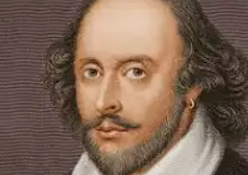

In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
import requests
import torch

# Step 1: Download and combine multiple Shakespeare texts
urls = [
    "https://www.gutenberg.org/files/1041/1041-0.txt",  # Hamlet
    "https://www.gutenberg.org/files/152/152-0.txt",   # Macbeth
    "https://www.gutenberg.org/files/1112/1112-0.txt"   # Othello
]

# Initialize an empty string to hold all text
all_text = ""

# Download each text file and append to all_text
for url in urls:
    response = requests.get(url)
    text = response.text
    all_text += text + "\n\n"  # Separate texts by newlines

# Save combined text to a single file
with open("combined_shakespeare.txt", "w", encoding="utf-8") as file:
    file.write(all_text)


# Step 3: Load the formatted text into a Hugging Face Dataset
with open("combined_shakespeare.txt", "r", encoding="utf-8") as file:
    formatted_data = file.read()

# Create a simple dataset from the formatted text
dataset = Dataset.from_dict({"text": formatted_data.split("\n\n")})  # Split into paragraphs

# Step 4: Tokenize the dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Set the pad_token to eos_token if it's not already set
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to eos_token

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=512)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Step 5: Initialize the GPT-2 model for fine-tuning
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Step 6: Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to=["none"],  # Disable Weights & Biases logging
    logging_steps=10,
)

# Step 7: Initialize the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Set to False because GPT-2 is not a masked language model
)

# Step 8: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,  # If you have a separate eval dataset
    data_collator=data_collator
)

# Step 9: Train the model
trainer.train()

# Step 10: Generate Text
# After training is complete, you can use the model to generate text

# Step 10.1: Check if GPU is available and set the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Step 10.2: Move the model to the appropriate device (GPU or CPU)
model.to(device)



Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss
500,4.007100,nan


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [31]:
# Step 10.3: Tokenize the prompt and move the input tensor to the same device
prompt = "Look in thy glass and tell the face thou viewest"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Explicitly set the attention mask and pad_token_id
inputs["attention_mask"] = inputs["attention_mask"].to(device)
inputs["input_ids"] = inputs["input_ids"].to(device)
inputs["pad_token_id"] = tokenizer.pad_token_id  # Ensure padding token ID is set

# Step 10.4: Generate text using the model
generated_text = model.generate(
    inputs["input_ids"],  # Use the input tensor
    max_length=40,
    num_return_sequences=1,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.pad_token_id  # Pass pad_token_id here as well
)

# Step 10.5: Decode and print the generated text
output = tokenizer.decode(generated_text[0], skip_special_tokens=True)
print(output)


Look in thy glass and tell the face thou viewest,
And thou shalt be the fairest of all the faire,
And thou shalt be the fairest of all the fairest.

